# Introduction to time-series analysis of HyP3 product with MintPy

1. Introduction
This notebook shows you how to do time-series analysis against HyP3 product with MintPy. This tutorial assumes that you have already successfully installed the MintPy and created the conda environment.
Detail installation info is refferered at https://github.com/insarlab/MintPy.

2. Run the application

Before running the program, some package need to be installed and imported.

In [1]:
!conda install -y -c conda-forge hyp3_sdk

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
import os, sys
import re
import glob
import zipfile
import json
from typing import no_type_check
from datetime import datetime, timezone
import numpy as np
from argparse import ArgumentParser
import hyp3_sdk as sdk
from hyp3_sdk import asf_search

2.1. Download the hyp3 data

set the home directory, project name, output directory, and granule_list file. The granule_list file includes the RTC
file names that users wants to use them to produce the interferograms for the time-series analysis purpose. Users
usually provide this file preapred with ASF vertex (https://serach.asf.alaska.edu).

In [3]:
hyp3_mintpy_home = "/home/jzhu4/projects/work/hyp3/hyp3-mintpy"
projectname = "case5"
outdir = "/media/jzhu4/data/hyp3-mintpy/case5"
granule_list = "/media/jzhu4/data/hyp3-mintpy/case5/granule.dat"
os.chdir(outdir)

user autentication

In [4]:
hyp3 = sdk.HyP3(prompt = True)

NASA Earthdata Login username: cirrusasf
NASA Earthdata Login password: ········


submit the jobs with hyp3-sdk and download the 

In [16]:
def run_job(hyp3, granule_list_file, projectname, outdir):
    #read the granulelist file
    with open(granule_list_file) as f:
        lines = f.read().splitlines()

    num = len(lines)
    reference_id = lines[num-1]  
    insar_jobs = sdk.Batch()
    
    for i in range(num-2, 0, -1):
        secondary_id = lines[i]
        job_name = projectname
        insar_jobs += hyp3.submit_insar_job(reference_id, secondary_id, job_name,
                                    include_look_vectors=True, include_inc_map=True,
                                    include_los_displacement=True, include_dem=True,
                                    include_wrapped_phase=True)

    #check and download the job
    if not insar_jobs.complete():
        # to get updated information
        insar_jobs = hyp3.refresh(insar_jobs)
        # or to wait until completion and get updated information (which will take a fair bit)
        insar_jobs = hyp3.watch(insar_jobs)

    #download the jobs files
    os.system("mkdir -p {}".format(outdir))
    os.chdir(outdir)
    insar_jobs.download_files()
    print("completed ...")

run_job(hyp3, granule_list, projectname, outdir)
print("downloaded the insar zip files are stored at {}.format(outdir)")

  0%|          | 0/6 [timeout in 10800 s]

  0%|          | 0/6 [00:00<?, ?it/s]

S1AA_20160604T205107_20160628T205108_VVP024_INT80_G_ueF_96AB.zip:   0%|          | 0/286347599 [00:00<?, ?it/s…

S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525.zip:   0%|          | 0/193726530 [00:00<?, ?it/s…

S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC.zip:   0%|          | 0/194682778 [00:00<?, ?it/s…

S1AA_20160324T205112_20160628T205108_VVP096_INT80_G_ueF_62EF.zip:   0%|          | 0/194553477 [00:00<?, ?it/s…

S1AA_20160229T205112_20160628T205108_VVP120_INT80_G_ueF_61FE.zip:   0%|          | 0/193879523 [00:00<?, ?it/s…

S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414.zip:   0%|          | 0/194750212 [00:00<?, ?it/s…

completed ...
downloaded the insar zip files are stored at {}.format(outdir)


2.2 Configure the custom cfg file called projectname.cfg in the outdir

In [6]:
def config(template_file, data_dir, projectname):
    '''
    read in the template, produce the custom.txt and place inti inputs
    '''
    out_lines=[]
    with open(template_file) as file:
        lines = file.readlines()

    for line in lines:
        out_lines.append(line.replace('{DATA_DIR}', data_dir))
        
    outfile = "{}/{}.cfg".format(data_dir, projectname)
    out_fid = open(outfile, 'w')
    out_fid.write("".join(out_lines))
    return outfile

template_file ="/home/jzhu4/projects/work/hyp3/hyp3-mintpy/docs/hyp3_mintpy_template.cfg"
config_file = config(template_file, outdir, projectname)

prepare the data
Defore time-series analysis with mintpy, data must be in certain struct in the outdir.  

In [18]:
f=open(config_file)
lines = f.readlines()
print("\n".join(lines))
f.close()

mintpy.load.processor        = hyp3

##---------interferogram datasets:

mintpy.load.unwFile          = /media/jzhu4/data/hyp3-mintpy/case5/*/*unw_phase_clip.tif

mintpy.load.corFile          = /media/jzhu4/data/hyp3-mintpy/case5/*/*corr_clip.tif

##---------geometry datasets:

mintpy.load.demFile          = /media/jzhu4/data/hyp3-mintpy/case5/DEM/dem_clip.tif

##---------incAngleFile:

mintpy.load.incAngleFile    =  /media/jzhu4/data/hyp3-mintpy/case5/*/*inc_map_clip.tif





2.3 prepare the data
it includes making the data in the certain directory structure, clipping the whole geotiff files. 

In [19]:
from __future__ import print_function, absolute_import, division, unicode_literals
from osgeo import gdal

def open_gdal_file(filename):
    handle = gdal.Open(filename)
    return handle

def read_gdal_file_geo(filehandle, band=1):
    geotransform = filehandle.GetGeoTransform()
    geoproj = filehandle.GetProjection()
    return filehandle.RasterXSize, filehandle.RasterYSize, geotransform, geoproj

def getOrigins(files):

    ul = np.zeros((2,len(files)))
    lr = np.zeros((2,len(files)))

    for i in range(len(files)):
        x,y,trans,proj = read_gdal_file_geo(open_gdal_file(files[i]))
        ul[0,i] = trans[0]
        lr[0,i] = trans[0] + x*trans[1]
        ul[1,i] = trans[3]
        lr[1,i] = trans[3] + y*trans[5]

    return ul,lr,trans[1],trans[5]

def copyOrigins(files,all_coords,all_pixsize):
    ul = np.zeros((2,len(files)))
    lr = np.zeros((2,len(files)))

    for i in range(len(files)):
        coords = all_coords[i]
        ul[0,i] = coords[0]
        lr[0,i] = coords[2]
        ul[1,i] = coords[1]
        lr[1,i] = coords[3]
 
        if i == 0:
            xres = all_pixsize[i]
            yres = all_pixsize[i]

    return ul,lr,xres,yres

def cutGeotiffsByLine(files,all_coords=None,all_pixsize=None):

    if all_coords is None:
        ul,lr,xres,yres = getOrigins(files)
    else:
        ul,lr,xres,yres = copyOrigins(files,all_coords,all_pixsize)

    diff_ul = np.zeros((2,len(files)))

    diff_ul[0] = (max(ul[0])-ul[0])/xres    
    diff_ul[1] = -1*(min(ul[1])-ul[1])/(-1*yres)

    print("Difference list:")
    print(diff_ul)

    lrx = min(lr[0])
    lry = max(lr[1])
    lenx = (lrx-max(ul[0])) / xres
    leny = -1*(lry-min(ul[1])) / (-1*yres)
    if leny < 0:
        leny = abs(leny)
        diff_ul[1] = diff_ul[1] * -1
    print("Size of output images {} x {}".format(lenx, leny))

    outfiles = []   
    for i in range(len(files)):
        outfile = files[i].replace(".tif","_clip.tif")
        if all_coords is not None:
            outfile = os.path.basename(outfile)
        print("Processing file {} to create file {}".format(files[i], outfile))
        gdal.Translate(outfile,files[i],srcWin=[diff_ul[0,i],diff_ul[1,i],lenx,leny],noData=0)
        outfiles.append(outfile)

    return(outfiles)

def get_sublist_via_pattern(lst, pattern_str):

    pattern = re.compile(pattern_str)

    return list(filter(pattern.search, lst))

def cutfiles(start_dir, pattern):
    '''
    clip off files in the start_dir and its sub-directories.

    '''
    files =[]
    for dir,_,_ in os.walk(start_dir):
        for item in pattern:
            files.extend(glob.glob(os.path.join(dir, item)))

    cutGeotiffsByLine(files)
    
    return

def prep_data_struc(data_dir):
    '''
    organize the data into the format that mintpy requests
    '''
    #unzip zip files in current directory
    filelist = glob.glob("{}/*.zip".format(data_dir))
    # split the filelist into two lists
    p1 = "/[A-Z][0-9][A-Z][A-Z]_"
    filelist1 = get_sublist_via_pattern(filelist, p1)
    p2 = "/[A-Z][0-9][A-Z]_" 
    filelist2 = get_sublist_via_pattern(filelist, p2)
    for file in filelist1:
        with zipfile.ZipFile(file, "r") as zip_ref:
            zip_ref.extractall(data_dir)

    # clip files
    cutfiles(data_dir, ["*.tif"])
    #copy a *.txt in one insar dirctory
    os.system("mkdir -p {}/DEM {}/inputs".format(data_dir, data_dir))
    prefix = filelist1[-1].split('.zip')[0]
    fileprefix = os.path.basename(prefix)
    txtfile = "{dir}/{fileprefix}.txt".format(dir = prefix, fileprefix = fileprefix)
    demfile = "{dir}/{fileprefix}_dem_clip.tif".format(dir = prefix, fileprefix = fileprefix)

    if os.path.exists(txtfile) and os.path.exists(demfile):
        cmd1 = "cp {file} {data_dir}/DEM/dem_clip.txt".format(file = txtfile, data_dir = data_dir)
        os.system(cmd1)
        cmd2 = "cp {file} {data_dir}/DEM/dem_clip.tif".format(file = demfile, data_dir = data_dir)    
        os.system(cmd2)
        return 0
    else:
        print("missing txt or dem file, can not continue. exit.")
        return 1


prep_data_struc(outdir)

Difference list:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.  10.  10.  10.
   10.  10.  10.  10.  10.  10.  12.  12.  12.  12.  12.  12.  12.  12.
   12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  10.  10.
   10.  10.  10.  10.  10.  10.  10.  10.  12.  12.  12.  12.  12.  12.
   12.  12.  12.  12.]
 [770. 770. 770. 770. 770. 770. 770. 770. 770. 770.  -0.  -0.  -0.  -0.
   -0.  -0.  -0.  -0.  -0.  -0.   2.   2.   2.   2.   2.   2.   2.   2.
    2.   2.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   2.   2.
    2.   2.   2.   2.   2.   2.   2.   2.  -0.  -0.  -0.  -0.  -0.  -0.
   -0.  -0.  -0.  -0.]]
Size of output images 3437.0 x 2069.0
Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160604T205107_20160628T205108_VVP024_INT80_G_ueF_96AB/S1AA_20160604T205107_20160628T205108_VVP024_INT80_G_ueF_96AB_los_disp.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160604T205107_20160628T205108_VVP024_INT80_G_ueF_96AB/S1AA_20160604T205107_20

Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC_vert_disp.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC_vert_disp_clip.tif
Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC_los_disp.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC_los_disp_clip.tif
Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC/S1AA_20160417T205113_20160628T205108_VVP072_INT80_G_ueF_F7CC_lv_theta.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA

Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525_vert_disp.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525_vert_disp_clip.tif
Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525_dem.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525_dem_clip.tif
Processing file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525/S1AA_20160511T205115_20160628T205108_VVP048_INT80_G_ueF_E525_wrapped_phase.tif to create file /media/jzhu4/data/hyp3-mintpy/case5/S1AA_2016

0

In [20]:
print("prepared data are at {}".format(outdir))

prepared data are at /media/jzhu4/data/hyp3-mintpy/case5


In [21]:
import subprocess
process = subprocess.run("tree {}".format(outdir), shell=True, check=True, stdout=subprocess.PIPE, universal_newlines=True)
output=process.stdout
print(output)

/media/jzhu4/data/hyp3-mintpy/case5
├── case5.cfg
├── DEM
│   ├── dem_clip.tif
│   └── dem_clip.txt
├── granule.dat
├── inputs
├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_amp_clip.tif
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_amp.tif
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_color_phase.kmz
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_color_phase.png
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_color_phase.png.aux.xml
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_corr_clip.tif
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_corr.tif
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_dem_clip.tif
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_1414_dem.tif
│   ├── S1AA_20160205T205112_20160628T205108_VVP144_INT80_G_ueF_14

2.4 Run Time-series Analysis application


In [7]:
from mintpy import smallbaselineApp
argv =[]
argv.append(config_file)
smallbaselineApp.main(argv)


___________________________________________________________

  /##      /## /##             /##     /#######           
 | ###    /###|__/            | ##    | ##__  ##          
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/ 
          MintPy v1.3.0, 2021-03-06
___________________________________________________________

--RUN-at-2021-06-08 11:20:55.864857--
Current directory: /media/jzhu4/data/hyp3-mintpy/case5
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'referenc

Input data seems to be geocoded. Lookup file not needed.
No local oscillator drift correction is needed for Sen.


******************** step - correct_SET ********************
Input data seems to be geocoded. Lookup file not needed.
No solid Earth tides correction.


******************** step - correct_troposphere ********************
Input data seems to be geocoded. Lookup file not needed.
Atmospheric correction using Weather Re-analysis dataset (PyAPS, Jolivet et al., 2011)
Weather Re-analysis dataset: ERA5
['/media/jzhu4/data/hyp3-mintpy/case5/timeseries_ERA5.h5'] exists and is newer than ['/media/jzhu4/data/hyp3-mintpy/case5/timeseries.h5'] --> skip.


******************** step - deramp ********************
No phase ramp removal.


******************** step - correct_topography ********************
Input data seems to be geocoded. Lookup file not needed.

dem_error.py /media/jzhu4/data/hyp3-mintpy/case5/timeseries_ERA5.h5 -t /media/jzhu4/data/hyp3-mintpy/case5/smallbaselineApp.cfg 

number of pixels to invert: 2552043 out of 7111153 (35.9%)
estimate time functions via linalg.lstsq ...
open file: /media/jzhu4/data/hyp3-mintpy/case5/velocity.h5 with "a" mode
write dataset /velocity             block: [0, 2069, 0, 3437]
write dataset /velocityStd          block: [0, 2069, 0, 3437]
close HDF5 file /media/jzhu4/data/hyp3-mintpy/case5/velocity.h5
time used: 00 mins 1.1 secs.


******************** step - geocode ********************
dataset is geocoded, skip geocoding and continue.


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /media/jzhu4/data/hyp3-mintpy/case5/velocity.h5 -o /media/jzhu4/data/hyp3-mintpy/case5/velocity.kmz
read mask from file: maskTempCoh.h5
colormap: jet
plotting data ...
create figure in size: [19.934267762203962, 12.0]
show reference point
writing /media/jzhu4/data/hyp3-mintpy/case5/velocity.png with dpi=600
writing /media/jzhu4/data/hyp3-mintpy/case5/velo

2.5 Display the analysis results

There are a few scripts used to display the analysis results. There are in the MINTPY_HOME/mintpy. Here we show two majoy disaply scripts.

2.5.1 Disaply velocity of displacement


In [10]:
from mintpy import view
file = "velocity.h5"
argv =[]
argv.append(file)
print(argv)

['velocity.h5']


run view.py in MintPy release version v1.3.0, release date 2021-03-06
input file is velocity file: /media/jzhu4/data/hyp3-mintpy/case5/velocity.h5 in float32 format
file size in y/x: (2069, 3437)
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (2):
['velocity', 'velocityStd']
data   coverage in y/x: (0, 0, 3437, 2069)
subset coverage in y/x: (0, 0, 3437, 2069)
data   coverage in lat/lon: (605760.0, 4051680.0, 880720.0, 3886160.0)
subset coverage in lat/lon: (605760.0, 4051680.0, 880720.0, 3886160.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 2
row     number: 1
column  number: 2
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png


<IPython.core.display.Javascript object>


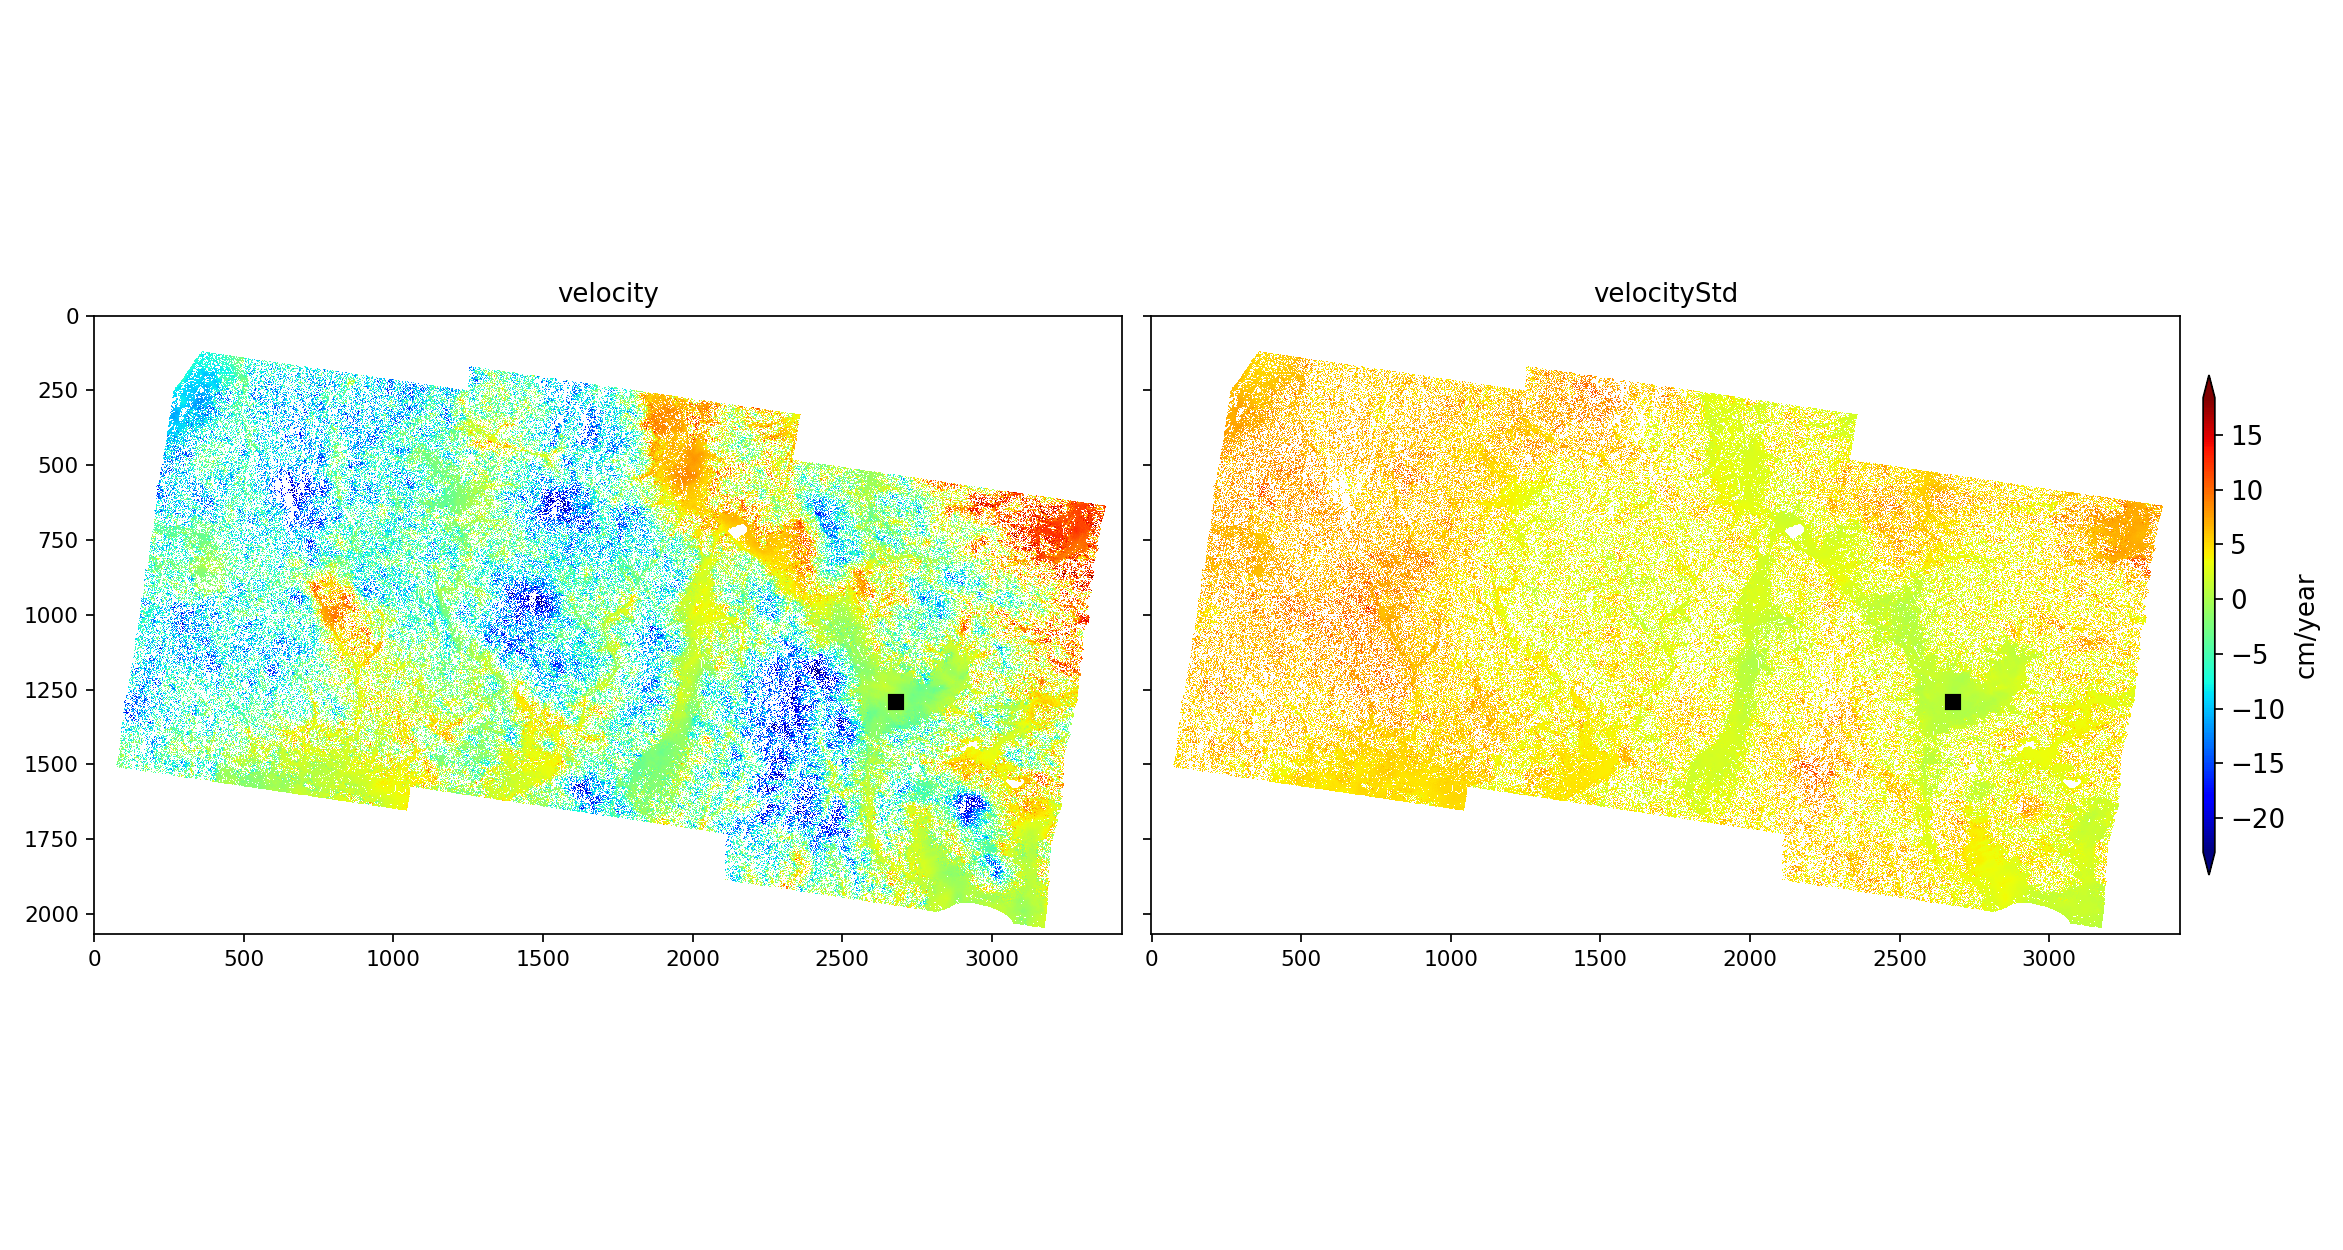

reading data as a list of 2D matrices ...
[==================================================] velocityStd 0s /     0s 
data    range: [-29.88454, 24.151205] cm/year
display range: [-29.88454, 24.151205] cm/year
masking data
plotting ...
[==================================================] velocityStd 0s /     0s 
data    range: [-29.88454, 24.151205] cm/year
display range: [-23.108265, 18.37946] cm/year
show colorbar
showing ...


In [12]:
%matplotlib notebook
view.main(argv)

2.5.2 Display the time-series of displacement

In [13]:
from mintpy import tsview

os.chdir(outdir)

file="timeseries.h5"
argv =[]
argv.append(file)
print(argv)

['timeseries.h5']


tsview.py timeseries.h5
open timeseries file: timeseries.h5
exclude date:['20160417']
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 3437, 2069)
subset coverage in y/x: (0, 0, 3437, 2069)
data   coverage in lat/lon: (605760.0, 4051680.0, 880720.0, 3886160.0)
subset coverage in lat/lon: (605760.0, 4051680.0, 880720.0, 3886160.0)
------------------------------------------------------------------------
reading timeseries from file timeseries.h5 ...
reference to date: 20160205
read mask from file: maskTempCoh.h5
data    range: [-15.263035, 15.481949] cm
display range: [-8.035415, 8.972845] cm
figure size : [9.58, 6.00]


<IPython.core.display.Javascript object>


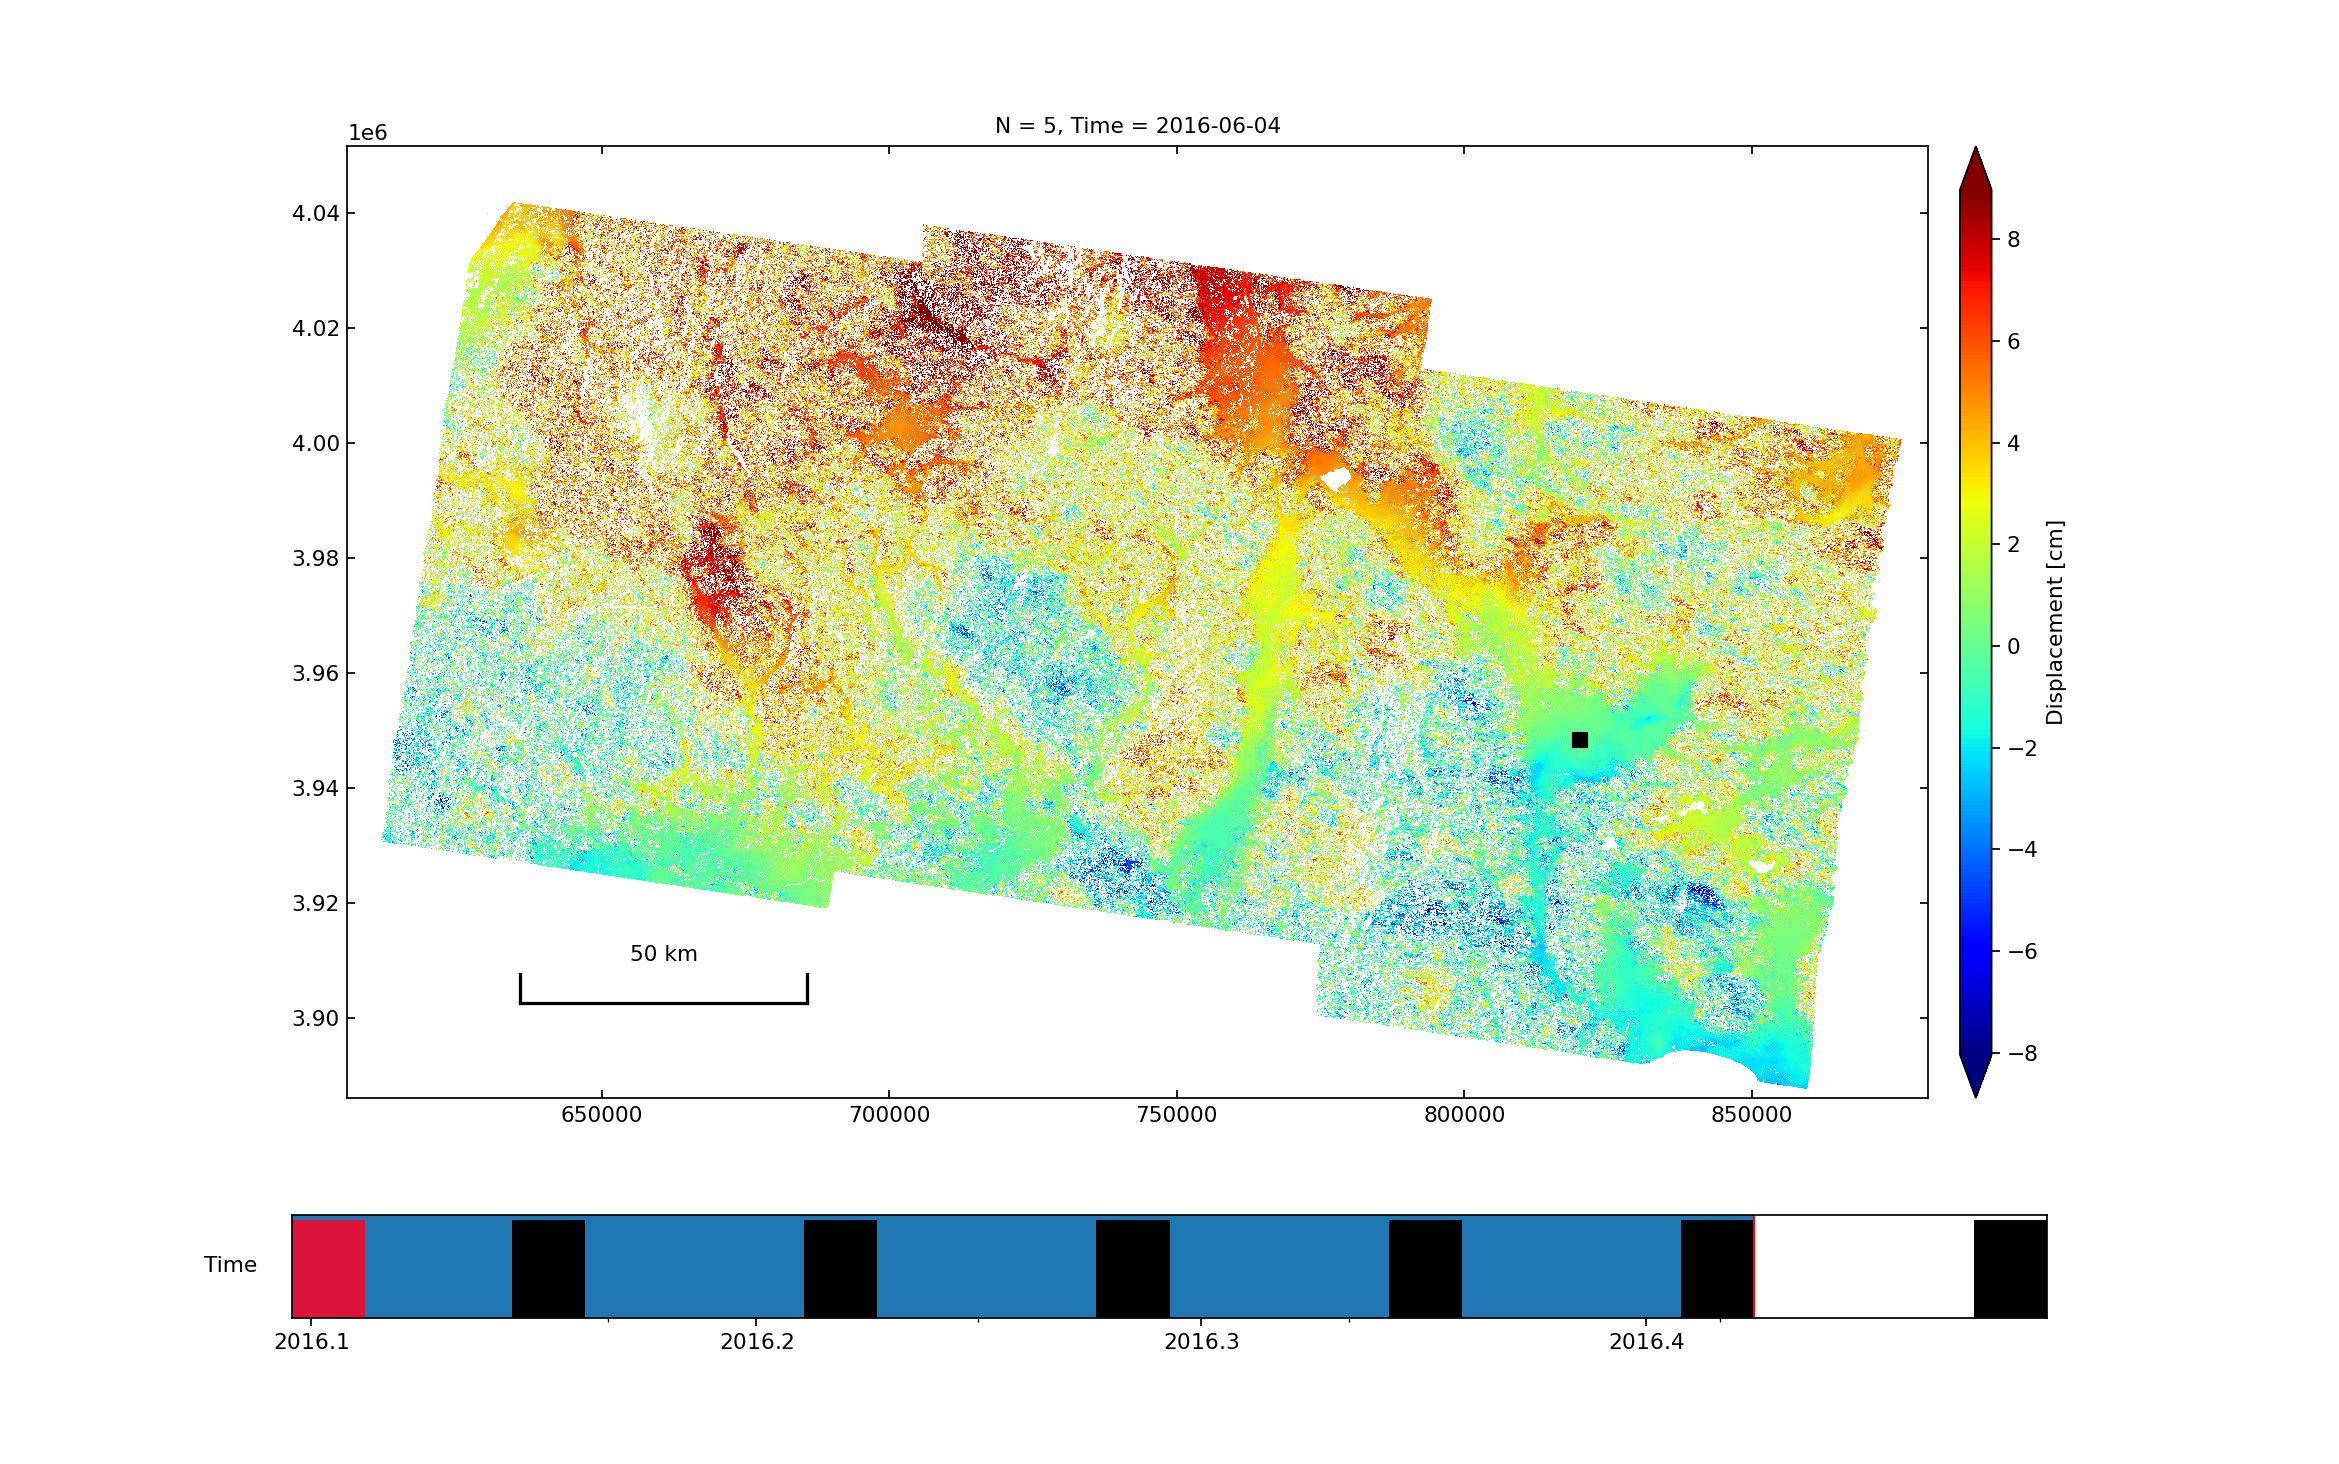

display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point


<IPython.core.display.Javascript object>


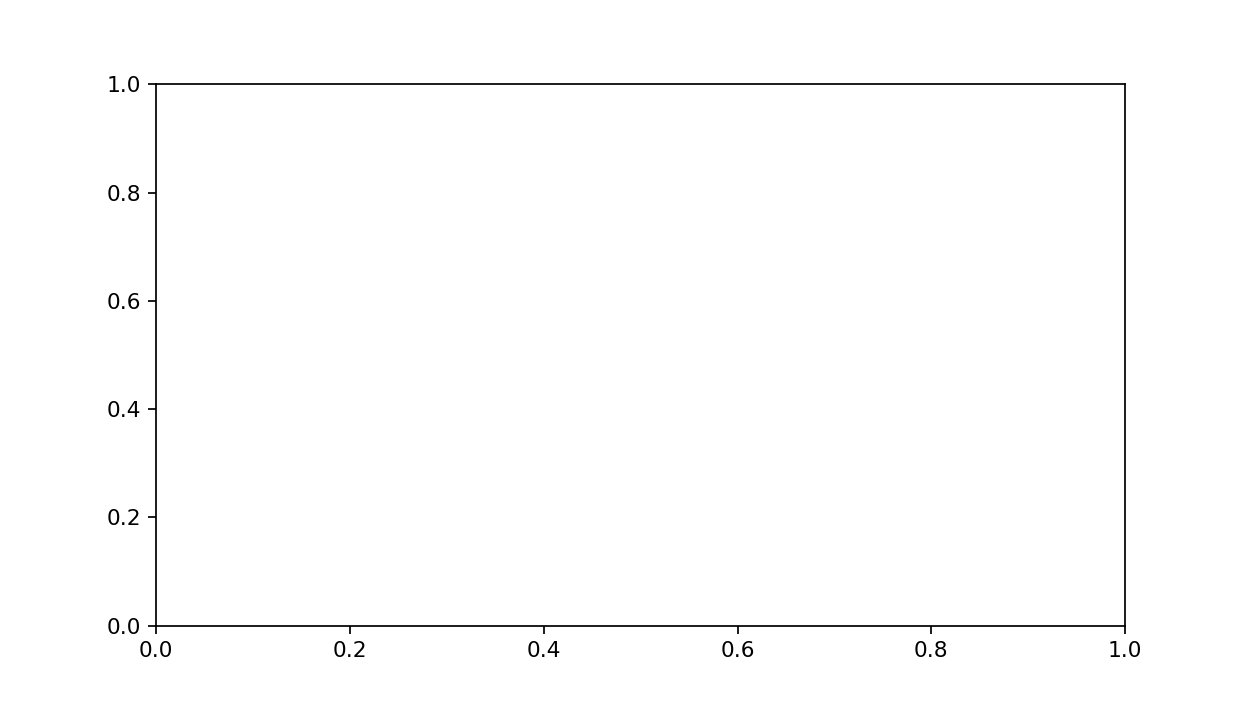

showing ...

------------------------------------------------------------------------
To scroll through the image sequence:
1) Move the slider, OR
2) Press left or right arrow key (if not responding, click the image and try again).
------------------------------------------------------------------------


In [14]:
%matplotlib notebook
tsview.main(argv)